In [ ]:
import pickle
import numpy as np


X = pickle.load(open('hydrogen_input_output.pkl', 'rb'))['x']
print("shape of X:", np.shape(X))

y = pickle.load(open('hydrogen_input_output.pkl', 'rb'))['y']
print("shape of y:", np.shape(y))

def functionXY(Xinput):
  for i, input in enumerate(X):
    if np.array_equal(Xinput, input):
      return y[i]
  return None

# Just Testing out functionXY():
print(X[56])
print(y[56])

print(functionXY(X[56]))

shape of X: (98694, 7)
shape of y: (98694,)
[0.05436893 0.54681128 0.41890404 0.90909091 0.0797649  0.2263727
 0.1648951 ]
10.44
10.44


In [ ]:
# Evolutionary PSO code:

import numpy as np
import random

def objective_function(x):
    # x is a tuple of discrete feature values, corresponding to each feature in X

    # Convert the input tuple to a NumPy array
    x = np.array(x)

    # Find the closest data point in the dataset
    distances = np.sum((X - x)**2, axis=1)
    closest_index = np.argmin(distances)

    # Snap the input to the closest data point
    snapped_input = X[closest_index]

    return y[closest_index]

def clip_position(x):
    x = np.array(x)
    
    distances = np.sum((X - x)**2, axis=1)
    closest_index = np.argmin(distances)
    
    snapped_input = X[closest_index]
    
    return snapped_input

def closest_index(x):
    x = np.array(x)
    
    distances = np.sum((X - x)**2, axis=1)
    closest_index = np.argmin(distances)
    return closest_index  

class Particle:
    def __init__(self, num_dimensions, lower_bound, upper_bound, init_position, index):
        self.position = init_position
        self.velocity = np.zeros(num_dimensions)
        self.best_position = np.copy(self.position)
        self.best_fitness = objective_function(self.position)
        self.index = index
        self.positions_traversed = [closest_index(init_position)]

class PSO:
    def __init__(self, num_particles, num_dimensions, lower_bound, upper_bound, w, c1, c2, num_iterations, init_positions):
        self.num_particles = num_particles
        self.num_dimensions = num_dimensions
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.num_iterations = num_iterations
        self.particles = [Particle(num_dimensions, lower_bound, upper_bound, init_positions[ind], ind) for ind in range(num_particles)]
        self.global_best_position = np.copy(self.particles[0].position)
        self.global_best_fitness = self.particles[0].best_fitness
        self.unique_function_call_ids = []
        self.global_max_for_each_unique_function_call = []

    def update_particles(self):
        for particle in self.particles:
            # Update velocities
            particle.velocity = (self.w * particle.velocity
                                 + self.c1 * np.random.rand() * (particle.best_position - particle.position)
                                 + self.c2 * np.random.rand() * (self.global_best_position - particle.position))

            if(np.linalg.norm(particle.velocity) > 1.0):
                particle.velocity = particle.velocity / np.linalg.norm(particle.velocity)

            # Update positions
            particle.position = particle.position + particle.velocity

            # Clip positions to stay within bounds
            particle.position = np.clip(particle.position, self.lower_bound, self.upper_bound)
            particle.position = clip_position(particle.position)
            
            particle.positions_traversed.append(closest_index(particle.position))


    def update_personal_and_global_bests(self):
        for particle in self.particles:
            unique_function_called = False
            if closest_index(particle.position) not in self.unique_function_call_ids:
                self.unique_function_call_ids.append(closest_index(particle.position))
                unique_function_called = True
            # Evaluate fitness
            current_fitness = objective_function(particle.position)

            # Update personal best
            if current_fitness > particle.best_fitness:
                particle.best_position = np.copy(particle.position)
                particle.best_fitness = current_fitness

                # Update global best
                if current_fitness > self.global_best_fitness:
                    self.global_best_position = np.copy(particle.position)
                    self.global_best_fitness = current_fitness
            
            if (unique_function_called == True):
                self.global_max_for_each_unique_function_call.append(self.global_best_fitness)

            #print("Particle #", particle.index, ": ")
            #print("-> Current Position: ", particle.position)
            #print("-> Current Velocity: ", particle.velocity)
            #print("-> Current Output: ", functionXY(particle.position))
            #print("-> Personal Best Position: ",  particle.best_position)
            
        #print("---> Global Best Position: ", self.global_best_position, " <---")
        #print("---> Global Best Output: ", functionXY(self.global_best_position), " <---")    
        
    def eliminate(self):
        #print(self.particles[1].position)
        #print(functionXY(self.particles[1].position))
        #print(clip_position(self.particles[1].position))
        #print(functionXY(clip_position(self.particles[1].position)))
        #print( (self.particles[0].position in X) )
        #print( (self.particles[1].position in X) )
        #print( (clip_position(self.particles[1].position) in X))
        
        num_to_eliminate = int((self.num_particles / (self.num_iterations - 1)))
        if not self.particles:
            return []
        
        for _ in range(num_to_eliminate):
            min_index = 0
            for j in range(1, len(self.particles)):
                
                #print( type(functionXY(self.particles[j].position)) )
                #print( type(functionXY(self.particles[min_index].position)) )
                      
                if (functionXY(clip_position(self.particles[j].position)) < functionXY(clip_position(self.particles[min_index].position))):
                    min_index = j
            
            
            self.particles.pop(min_index)
            #print("eliminated index ", min_index)
        
    def optimize(self):
        all_positions_traversed = []
        for i in range(self.num_particles):
            all_positions_traversed.append([0.0])

        #print(all_positions_traversed)

        for particle in self.particles:
            if closest_index(particle.position) not in self.unique_function_call_ids:
                self.unique_function_call_ids.append(closest_index(particle.position))
            if particle.best_fitness > self.global_best_fitness:
                self.global_best_position = np.copy(particle.position)
                self.global_best_fitness = particle.best_fitness
                self.global_max_for_each_unique_function_call.append(self.global_best_fitness)

        for i in range(self.num_iterations):
            #print("Iteration #", i, ": ")
            #print("x-x-x-x-x-x-x-x-x-x-x")
            self.update_particles()
            self.update_personal_and_global_bests()
            for j in range(self.num_particles):
                for k in self.particles:
                    if(j == k.index):
                        all_positions_traversed[j] = k.positions_traversed


            if (i != (self.num_iterations - 1)):
                self.eliminate()
            #print("Particles remaining after Iteration #", i, ": ", len(self.particles))            

        return self.global_best_position, self.global_best_fitness, all_positions_traversed, self.unique_function_call_ids, self.global_max_for_each_unique_function_call

# Example usage
num_particles = 10
num_dimensions = 7
lower_bound = 0
upper_bound = 1.0
w = 2.0
c1 = 1.0
c2 = 1.0
num_iterations = 10


initial_positions_PSO = random.choices(X, k=num_particles)
print(initial_positions_PSO)

pso = PSO(num_particles, num_dimensions, lower_bound, upper_bound, w, c1, c2, num_iterations, initial_positions_PSO)
best_position, best_fitness, all_positions, all_function_calls, global_max_per_function_call = pso.optimize()

print("Best position found: ", best_position)
print("Best fitness found: ", best_fitness)
print("All_positions: ", all_positions)
print("All_function_calls: ", all_function_calls)
print("Global_max_per_function_call: ", global_max_per_function_call)


[array([0.13592233, 0.26703487, 0.47503141, 0.71717172, 0.02714805,
       0.11065862, 0.09412587]), array([0.26213592, 0.        , 0.        , 0.41414141, 0.00811643,
       0.05364415, 0.02111888]), array([0.15533981, 0.17679692, 0.35937492, 0.63636364, 0.02127064,
       0.11079905, 0.08097902]), array([0.10485437, 0.40695179, 0.56980941, 0.77777778, 0.0375035 ,
       0.11655666, 0.13118881]), array([0.15145631, 0.19348205, 0.38351247, 0.64646465, 0.02211027,
       0.10405842, 0.09776224]), array([0.13398058, 0.27107385, 0.47883114, 0.74747475, 0.02854744,
       0.19042269, 0.09300699]), array([0.10679612, 0.39083385, 0.55555667, 0.81818182, 0.03890288,
       0.17216683, 0.1013986 ]), array([0.12815534, 0.25198974, 0.44355222, 0.72727273, 0.02826756,
       0.15011937, 0.11076923]), array([0.08737864, 0.47597231, 0.55890584, 0.80808081, 0.04645956,
       0.15152366, 0.10335664]), array([0.14368932, 0.32714974, 0.61693809, 0.6969697 , 0.02490904,
       0.07260216, 0.06699301])]

In [ ]:
!pip install SciencePlots

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# now, with this information, we'll try to see how it looks like on a graph, via visualizations.ipynb
import numpy as np 
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import torch
import seaborn as sns
from sklearn.decomposition import PCA
import scienceplots

plt.matplotlib.style.use(['science','nature'])
cool_colors = ['#0A84A4', '#F6C95E', '#6F4E7C', '#9DD967', '#CB472E', '#FFA157', '#8CDCD0']

plt.rcParams.update(plt.rcParamsDefault)

search_to_color = {'BO': cool_colors[0], 'random': cool_colors[1], 'evolutionary': cool_colors[2], 'RF': cool_colors[3], 'RF (div)': cool_colors[5]}

In [ ]:
X = pickle.load(open('hydrogen_input_output.pkl', 'rb'))['x']
print("shape of X:", np.shape(X))

y = pickle.load(open('hydrogen_input_output.pkl', 'rb'))['y']
print("shape of y:", np.shape(y))

nb_COFs = pickle.load(open('hydrogen_input_output.pkl', 'rb'))['nb_COFs']
print("# COFs:", nb_COFs)

nb_runs = pickle.load(open('hydrogen_input_output.pkl', 'rb'))['nb_runs']
print("# runs:", nb_runs)

nb_iterations = pickle.load(open('hydrogen_input_output.pkl', 'rb'))['nb_iterations']
print("# iterations:", nb_iterations)

# feature names
features = pickle.load(open('hydrogen_input_output.pkl', 'rb'))['features']
print(features)

shape of X: (98694, 7)
shape of y: (98694,)
# COFs: 98694
# runs: 50
# iterations: 100
['Density', 'GSA', 'VSA', 'VF', 'PV', 'LCD', 'PLD']


In [ ]:
pca = PCA(n_components=2)
pca.fit(X)
X_2D = pca.transform(X)

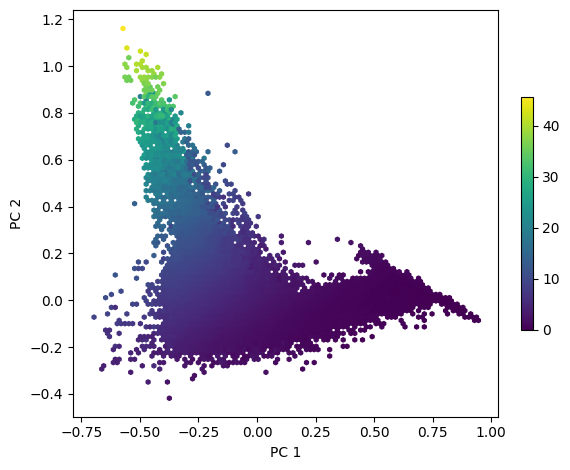

In [ ]:
#low dimensional (PCA) visualization of the entire dataset
plt.hexbin(X_2D[:, 0], X_2D[:, 1], C=y)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
cb = plt.colorbar(fraction=0.02, pad=0.04)
# cb.set_label(label="deliverable capacity\n[L STP/L]")
plt.xticks()
plt.yticks()
plt.gca().set_aspect('equal', 'box')
plt.tight_layout()
plt.savefig('feature_space_colored_by_DC.pdf')
plt.show()

[[62133, 42363, 12199, 8, 6325, 30919, 36414, 36414], [96609, 77387], [70810, 71631, 43978, 45, 6325, 30919, 36414, 36414, 36414], [50013, 50013, 35907, 3397, 22242, 30919, 36414, 36414, 36414, 36414], [71366, 65619, 49358], [46351, 45183, 23531, 8, 46615, 29415], [15776, 28256, 17103, 1602, 8300, 29415, 36414, 36414, 36414, 36414, 36414], [62265, 45503, 23972, 45, 8], [33082, 33082, 33082, 15376], [72314, 33009, 3397, 15734, 30919, 30919, 30919]]
[62133, 96609, 70810, 50013, 71366, 46351, 15776, 62265, 33082, 72314]
[42363, 77387, 71631, 50013, 65619, 45183, 28256, 45503, 33082, 33009]
[12199, 43978, 35907, 49358, 23531, 17103, 23972, 33082, 3397]
[8, 45, 3397, 8, 1602, 45, 15376, 15734]
[6325, 6325, 22242, 46615, 8300, 8, 30919]
[30919, 30919, 30919, 29415, 29415, 30919]
[36414, 36414, 36414, 36414, 30919]
[36414, 36414, 36414, 36414]
[36414, 36414, 36414]
[36414, 36414]
[36414]


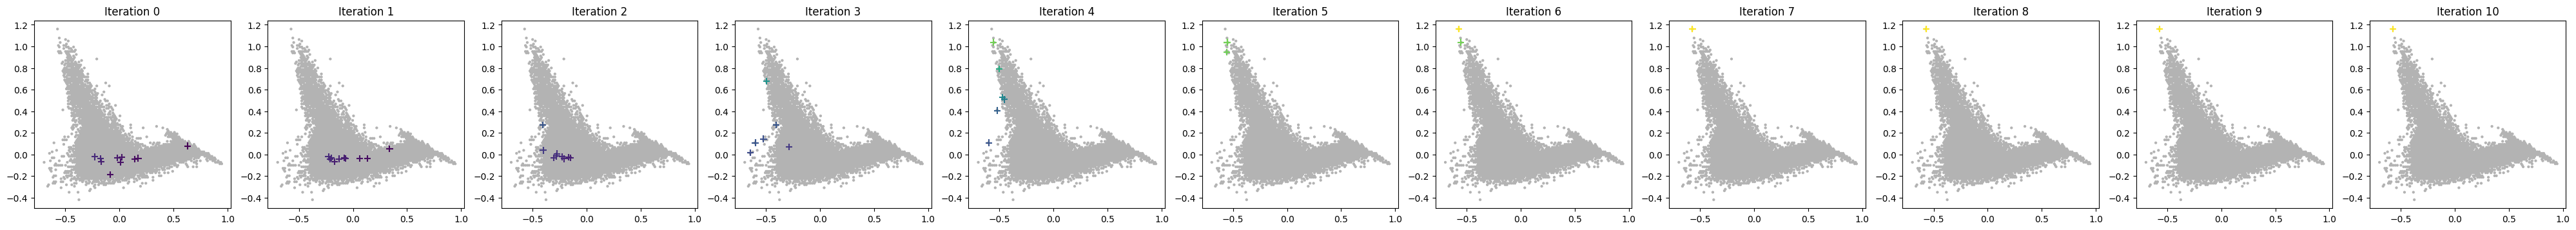

In [ ]:
fig, ax = plt.subplots(1, (num_iterations + 1), figsize=(40, 40))
fig.tight_layout()
print(all_positions)


for a in ax:
    a.set_aspect('equal', 'box')
    a.hexbin(X_2D[:, 0], X_2D[:, 1], C=0.3 * np.ones(nb_COFs), cmap="binary", vmin=0, vmax=1)

for i in range( (num_iterations + 1) ):

    ids_acquired = []
    for id in all_positions:
        if i < len(id):
            ids_acquired.append(id[i])

    print(ids_acquired)
    ax[i].scatter(X_2D[ids_acquired, 0], X_2D[ids_acquired, 1], c=y[ids_acquired], marker="+", s=55, vmin=cb.vmin, vmax=cb.vmax)
    ax[i].set_title('Iteration {}'.format(i))

plt.savefig("iterations_!.pdf", bbox_inches="tight")
plt.show()


31


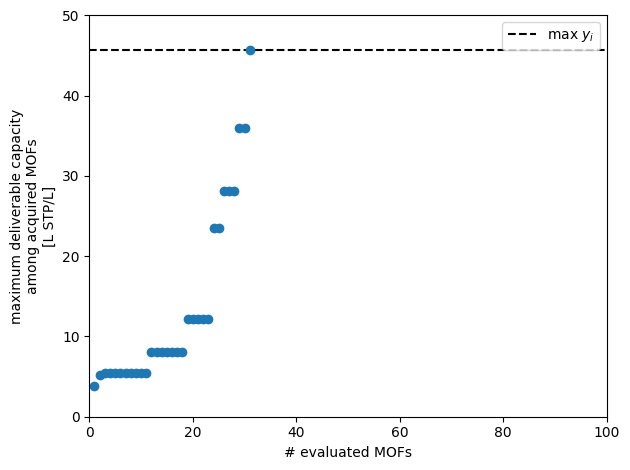

In [ ]:
x_values = np.arange(1, len(global_max_per_function_call) + 1)

print(len(global_max_per_function_call))

plt.figure()
#plt.plot(range(1, 101), y_maxes_this_run, color=search_to_color['BO'], clip_on=False)
# plt.scatter(nb_COFs_initialization, y_maxes_this_run[nb_COFs_initialization-1], color=search_to_color['BO'], marker="o")
plt.scatter(x_values, global_max_per_function_call)
plt.xlabel('# evaluated MOFs')
plt.ylabel('maximum deliverable capacity\namong acquired MOFs\n[L STP/L]')

plt.axhline(y=45.71, color="k", linestyle="--", label="$\max$ $y_i$", zorder=0)
# axs[0].set_ylim(ymin=0.0)
plt.xlim([0, 100])
plt.ylim([0, 50])
plt.legend()

plt.tight_layout()
plt.savefig("search_efficiency_for_specific_acquisition_run.pdf")
plt.show()

In [ ]:
# Running EPSO many times to generate averages

num_particles = 10
num_dimensions = 7
lower_bound = 0
upper_bound = 1.0
w = 2.0
c1 = 1.0
c2 = 1.0
num_iterations = 10

nb_runs = 50  # Number of runs of this we're doing!

gmpfc_arr = []
apt_arr = []

for run_no in range(nb_runs):
    print("Run No.: ", run_no)
    initial_positions_PSO = random.choices(X, k=num_particles)
    print("Initial Position for Run No. ", run_no, ": ", initial_positions_PSO)
    pso = PSO(num_particles, num_dimensions, lower_bound, upper_bound, w, c1, c2, num_iterations, initial_positions_PSO)
    best_position, best_fitness, all_positions, all_function_calls, global_max_per_function_call = pso.optimize()
    print("best_fitness for Run No. ", run_no, ": ", best_fitness)
    gmpfc_arr.append(global_max_per_function_call)
    apt_arr.append(all_function_calls)

print(gmpfc_arr)
print(apt_arr)

Run No.:  0
Initial Position for Run No.  0 :  [array([0.41359223, 0.        , 0.        , 0.42424242, 0.00531766,
       0.05350372, 0.03818182]), array([0.09708738, 0.48344513, 0.62450751, 0.81818182, 0.04282116,
       0.13551467, 0.11216783]), array([0.14368932, 0.26323795, 0.49459327, 0.67676768, 0.02434929,
       0.09998596, 0.0834965 ]), array([0.08543689, 0.41936513, 0.47898884, 0.82828283, 0.04897845,
       0.20895942, 0.12195804]), array([0.20194175, 0.09394564, 0.24441179, 0.5959596 , 0.01539323,
       0.07302345, 0.06      ]), array([0.13203883, 0.27751077, 0.48161211, 0.78787879, 0.03050658,
       0.15475355, 0.12027972]), array([0.07961165, 0.36512   , 0.38934473, 0.87878788, 0.05541562,
       0.35514675, 0.17916084]), array([0.05825243, 0.53783179, 0.43072375, 0.87878788, 0.07444724,
       0.25502036, 0.2172028 ]), array([0.13592233, 0.25770359, 0.4579902 , 0.70707071, 0.02686818,
       0.12835276, 0.10797203]), array([0.23883495, 0.07538564, 0.2310076 , 0.5555555

In [ ]:
with open('epso_graph_results.pkl', 'wb') as file:
    pickle.dump(gmpfc_arr, file)
    pickle.dump(apt_arr, file)

In [ ]:
num_iterations_per_run = []
for i in range(len(gmpfc_arr)):
    num_iterations_per_run.append(len(gmpfc_arr[i]))

print(num_iterations_per_run)
max_num_iterations = np.max(num_iterations_per_run)
print(max_num_iterations)

[28, 23, 23, 29, 23, 32, 19, 25, 26, 28, 34, 25, 29, 32, 31, 28, 23, 25, 22, 30, 40, 23, 29, 39, 26, 25, 28, 33, 23, 25, 31, 33, 33, 26, 31, 33, 22, 32, 28, 32, 29, 10, 23, 33, 16, 31, 23, 35, 24, 25]
40


In [ ]:
y_max_mu = []
y_max_sig_bot = []
y_max_sig_top = []

for i in range(max_num_iterations):
    y_maxes = []
    for j in range(nb_runs):
          if( i < len(gmpfc_arr[j]) ): #only if gmpfc_arr[j] has ith iteration!
              y_maxes.append(gmpfc_arr[j][i]) 

    print("y_maxes for iteration ", i, ": ", y_maxes)
    y_max_mu.append( np.mean(y_maxes) )
    print("y_max_mu[i]: ", y_max_mu[i])
    print("y_maxes < y_max_mu[i]: ", y_maxes < y_max_mu[i])

    y_maxes_L_y_max_mu_i = y_maxes < y_max_mu[i]
    y_max_sig_bot_temp = []
    for k in range(len(y_maxes_L_y_max_mu_i)):
        if (y_maxes_L_y_max_mu_i[k] == True):
            y_max_sig_bot_temp.append(y_maxes[k])
    y_max_sig_bot.append( np.std ( y_max_sig_bot_temp )  )
    print(y_max_sig_bot[i])

    y_maxes_G_y_max_mu_i = y_maxes > y_max_mu[i]
    y_max_sig_top_temp = []
    for k in range(len(y_maxes_G_y_max_mu_i)):
        if (y_maxes_G_y_max_mu_i[k] == True):
            y_max_sig_top_temp.append(y_maxes[k])
    y_max_sig_top.append( np.std ( y_max_sig_top_temp )  )
    print(y_max_sig_top[i])

print("y_max_mu: ", y_max_mu)
print("y_max_sig_bot: ", y_max_sig_bot)
print("y_max_sig_top: ", y_max_sig_top)


y_maxes for iteration  0 :  [5.26, 4.92, 2.52, 5.97, 8.37, 6.87, 4.41, 10.92, 5.56, 4.85, 10.22, 6.07, 7.94, 8.56, 10.56, 10.4, 14.8, 7.36, 5.58, 7.759999999999998, 4.07, 6.38, 6.81, 2.4, 16.34, 5.2, 5.89, 2.84, 6.35, 6.16, 2.05, 5.69, 0.53, 4.34, 7.8, 5.42, 4.46, 8.34, 7.99, 7.18, 7.53, 45.71, 6.92, 5.61, 6.07, 8.21, 10.07, 6.14, 5.92, 4.86]
y_max_mu[i]:  7.4436
y_maxes < y_max_mu[i]:  [ True  True  True  True False  True  True False  True  True False  True
 False False False False False  True  True False  True  True  True  True
 False  True  True  True  True  True  True  True  True  True False  True
  True False False  True False False  True  True  True False False  True
  True  True]
1.5674938909786156
8.799410447379604
y_maxes for iteration  1 :  [6.3, 14.93, 14.22, 5.97, 8.37, 6.87, 7.82, 10.92, 5.59, 10.49, 10.22, 10.14, 9.2, 8.56, 10.56, 10.4, 14.8, 21.75, 5.58, 7.759999999999998, 6.38, 7.46, 6.81, 3.69, 16.34, 10.44, 10.21, 3.74, 6.88, 6.61, 9.2, 5.8, 4.25, 6.91, 8.259999999999

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
np_y_max_mu = np.array(y_max_mu)
np_y_max_sig_bot = np.array(y_max_sig_bot)
np_y_max_sig_top = np.array(y_max_sig_top)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]


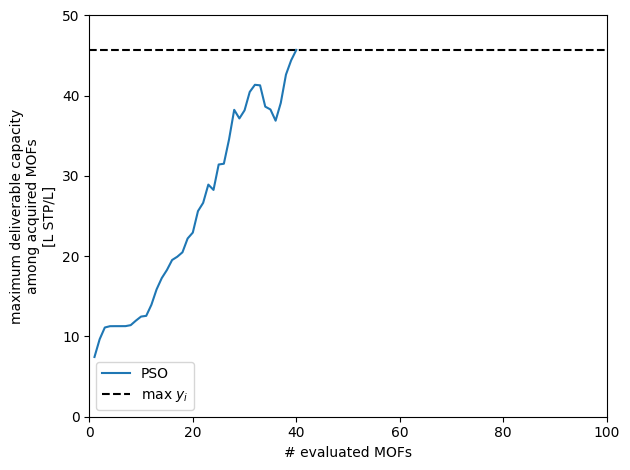

In [ ]:
x_values = np.arange(1, max_num_iterations + 1)
print(x_values)

plt.figure()
#plt.plot(range(1, 101), y_maxes_this_run, color=search_to_color['BO'], clip_on=False)
# plt.scatter(nb_COFs_initialization, y_maxes_this_run[nb_COFs_initialization-1], color=search_to_color['BO'], marker="o")
plt.plot(x_values, y_max_mu, label="PSO", clip_on=False)
plt.fill_between(max_num_iterations, np_y_max_mu - np_y_max_sig_bot, np_y_max_mu + np_y_max_sig_top, alpha=0.2, ec="None")

plt.xlabel('# evaluated MOFs')
plt.ylabel('maximum deliverable capacity\namong acquired MOFs\n[L STP/L]')

plt.axhline(y=45.71, color="k", linestyle="--", label="$\max$ $y_i$", zorder=0)
# axs[0].set_ylim(ymin=0.0)
plt.xlim([0, 100])
plt.ylim([0, 50])
plt.legend()

plt.tight_layout()
plt.savefig("search_efficiency_for_specific_acquisition_run.pdf")
plt.show()

In [ ]:
with open('epso_graph_outputs.pkl', 'wb') as file:
    pickle.dump({'y_max_mu_epso': y_max_mu, 'y_max_sig_bot_epso': y_max_sig_bot, 'y_max_sig_top_epso': y_max_sig_top}, file)

In [ ]:
ids_to_rank = np.argsort(y.squeeze())
print(ids_to_rank)

[98693 98134 98133 ... 35496 35235 36414]


In [ ]:
top_100_COF_ids = np.flip(np.argsort(y))[:100]
assert np.size(top_100_COF_ids) == 100
print("top 100 COFs range from y =", np.min(y[top_100_COF_ids]), "to", np.max(y[top_100_COF_ids]))

top 100 COFs range from y = 31.1 to 45.71


In [ ]:
def fraction_in_top100_cofs(ids_acquired):
    nb_in_top_100 = 0
    for id_acquired in ids_acquired:
        if id_acquired in top_100_COF_ids:
            nb_in_top_100 += 1
    return nb_in_top_100 / 100

In [ ]:
# get fraction of aquired COFs in top 100 for
def y_top_100(arr):
    y_top100_mu      = np.zeros(max_num_iterations)

    for i in range(max_num_iterations):
        y_ranks = []

        for j in range(nb_runs):
            temp = []
            if ( i < len(arr[j]) ): #only if arr[] has ith function call!
                for k in range(i):
                    temp.append(arr[j][k])
            else:
                temp = arr[j]

            y_ranks.append(temp)

        y_frac_top_100_per_run = []
        for l in y_ranks:
            y_frac_top_100_per_run.append(fraction_in_top100_cofs(l))


        np_y_frac_top_100_per_run = np.array(y_frac_top_100_per_run)

        y_top100_mu[i] = np.mean(np_y_frac_top_100_per_run)

    
    return y_top100_mu
    

y_top100_mu_epso = y_top_100(apt_arr)
print(y_top100_mu_epso)


[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.0002
 0.0002 0.0002 0.0004 0.0004 0.0004 0.0006 0.0006 0.0006 0.0008 0.001
 0.0012 0.0018 0.0022 0.0026 0.0028 0.003  0.0038 0.005  0.0062 0.0082
 0.0098 0.0116 0.0138 0.0162 0.0186 0.0212 0.0238 0.0262 0.029  0.0316]


In [ ]:
samples = [9, 19, 29, 39, 49]
print("Particle Swarm: ", y_top100_mu_epso[samples[0]], "| ", y_top100_mu_epso[samples[1]], "| ", y_top100_mu_epso[samples[2]], "| ", y_top100_mu_epso[samples[3]], "| ", y_top100_mu_epso[samples[3]], "| " )


Particle Swarm:  0.0002 |  0.001 |  0.0082 |  0.0316 |  0.0316 | 
